In [1]:
import pandas as pd
df = pd.read_excel('Online Retail.xlsx')

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Calculating Recency

In [3]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min').astype(int)
df_rec = df[df['rank']==1]

In [6]:
#To assign a recency score to each customerID
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

C:\Users\user\AppData\Local\Temp\ipykernel_12280\1931538317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


### Calculating Frequency

In [7]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

In [9]:
#The new dataframe we created consists of two columns — “CustomerID” and “frequency.” Let’s merge this dataframe with the previous one:
rec_freq = df_freq.merge(df_rec,on='CustomerID')

### Calculating Monetary Value

In [10]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [11]:
#The new dataframe we created consists of each CustomerID and its associated monetary value. Let’s merge this with the main dataframe:
rfm = m.merge(rec_freq,on='CustomerID')

In [12]:
finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

### Removing Outliers

recency: 


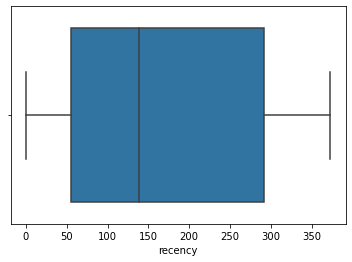

frequency: 


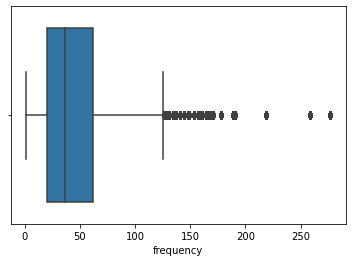

monetary_value: 


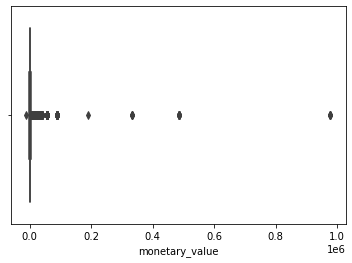

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

In [14]:
#Calculating Z-score.Removing every data point with a Z-Score>=3
from scipy import stats
import numpy as np
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1


### Standardization

In [16]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [18]:
scaled_features.head()

,recency,frequency,monetary_value
0,-1.196723,0.379971,0.185080
1,-1.120665,-0.259085,1.965919
2,1.752654,2.297138,0.401256
3,-0.715020,-0.259085,-0.217826
4,-0.596706,-0.350378,0.011294


Text(0, 0.5, 'Inertia')

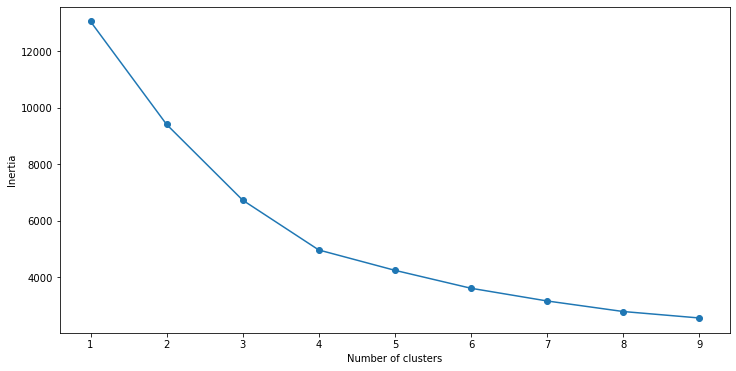

In [19]:
#Creating a loop and run the K-Means algorithm from 1 to 10 clusters. Then plotting it to select the elbow of the curve as the number of clusters to use.
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [20]:
#“elbow” of this graph is the point of inflection on the curve, and it is 4-cluster mark.This is the optimal no of clusters
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [21]:
#Evaluating performance of this model,we will use metric silhouette score.Coefficient value ranges from -1 to +1.A higher the better.
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.43605181033168217


In [22]:
#The silhouette coefficient of this model is 0.44, indicating reasonable cluster separation.

In [24]:
#we have built the segmentation model, we need to assign clusters to each customer in the dataset.
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

In [26]:
frame.head()

,recency,frequency,monetary_value,cluster
1,6,31,1246.73,0
32,15,17,4311.90,0
49,355,73,1618.81,2
122,63,17,553.25,0
139,77,15,947.61,0


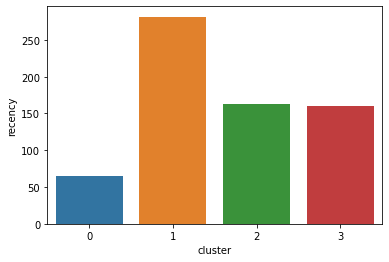

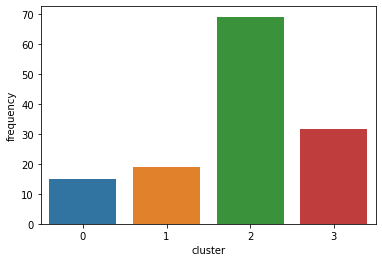

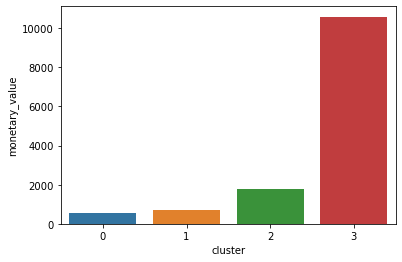

In [27]:
#Visualizing data
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

### Cluster - Customer Atributes

0 - Customers in this segment have low recency, frequency, and monetary value scores. These are people who make occasional purchases and are likely to visit the platform only when they have a specific product they’d like to buy.

1 - These customers are seen making purchases often and have visited the platform recently. Their monetary value is extremely high, indicating that they spend a lot when shopping online.This could mean that users in this segment are likely to make multiple purchases in a single order and are highly responsive to cross-selling and up-selling. Resellers who purchase products in bulk could also be part of this segment.

2 - Customers in this segment have been seen making purchases very frequently in the past. However, these are people who have stopped visiting the platform for some reason and haven’t been seen shopping on the site recently.This could mean several things — they were disappointed with the service and switched to a competitor platform, they no longer have any interest in the products sold, or their customer ID changed as they re-registered onto the platform with different credentials.

3 - This cluster consists of users who are new to the platform. They have the potential to become long-term consumers with high frequency and monetary value and should be targeted with special “new-user promotions” to instill brand loyalty.